In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

mushroom = pd.read_csv('mushrooms.csv')

In [30]:
mushroom['class']=mushroom['class'].replace(['p'],1)
mushroom['class']=mushroom['class'].replace(['e'],0)

In [46]:
seed = 50
y = pd.DataFrame(mushroom['class'])
X = pd.DataFrame(mushroom.drop('class', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [47]:
features_to_encode = X_train.columns[X_train.dtypes==object].tolist()

In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

In [50]:
from sklearn.pipeline import make_pipeline


In [51]:
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(X_train, y_train)

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'bruises',
                                                   'odor', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'gill-color', 'stalk-shape',
                                                   'stalk-root',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',

In [52]:
y_pred = pipe.predict(X_test)

In [53]:
y_pred

array([1, 0, 0, ..., 1, 1, 0])

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [55]:
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 99.0 %


In [56]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

In [57]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')


Train ROC AUC Score: 0.9989009846308069
Test ROC AUC  Score: 0.999158774565623


Baseline: 1.0 
 Test: 0.98 
 Train: 0.98
Baseline: 0.48 
 Test: 1.0 
 Train: 1.0
Baseline: 0.5 
 Test: 1.0 
 Train: 1.0


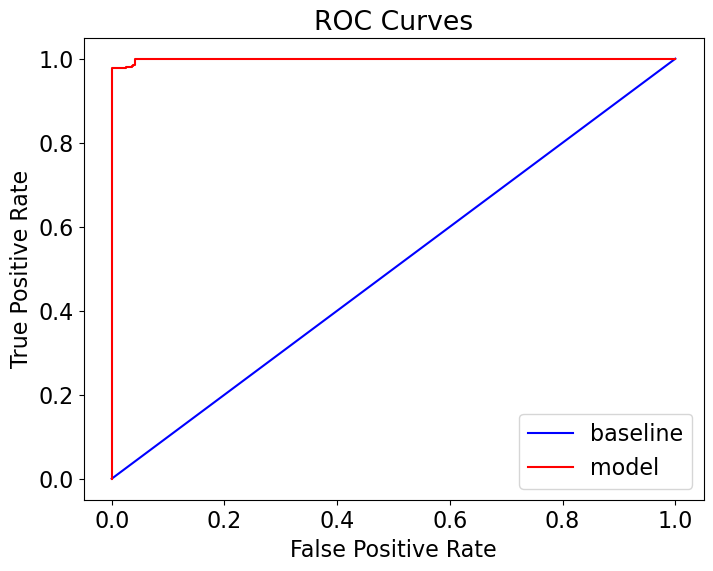

In [58]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
         print('Baseline:', round(baseline[metric], 2),'\n','Test:', round(results[metric], 2),'\n','Train:', round(train_results[metric], 2))

     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
evaluate_model(y_pred,probs,train_predictions,train_probs)

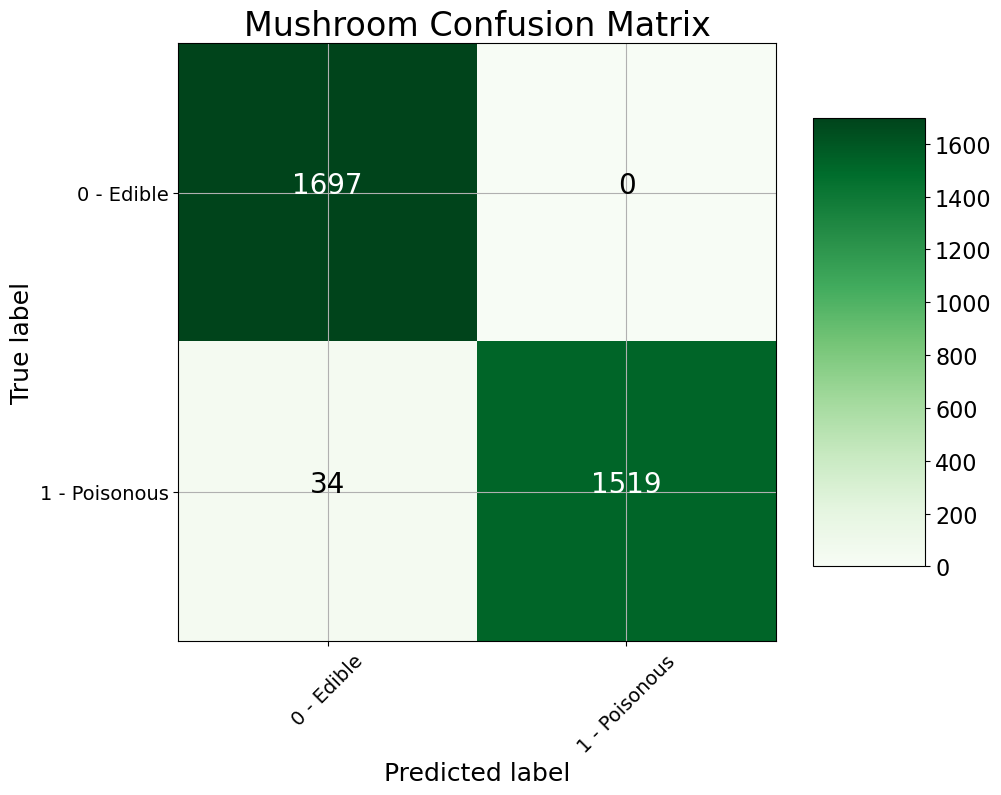

In [62]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Edible', '1 - Poisonous'],
                      title = 'Mushroom Confusion Matrix')

In [63]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[9.40167171e-04 0.00000000e+00 5.42454773e-04 1.13810261e-03
 0.00000000e+00 4.35541335e-04 3.83719323e-03 0.00000000e+00
 4.96934074e-03 1.02509700e-03 9.68083231e-04 0.00000000e+00
 2.48227330e-03 6.30932327e-04 7.85318778e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.58901839e-03 1.18033193e-03
 3.55816143e-02 1.73371690e-02 4.71710045e-03 4.86330899e-03
 9.52437293e-02 3.85217350e-03 0.00000000e+00 1.17942396e-01
 8.42213280e-03 8.32251548e-03 7.45852677e-03 1.26170060e-03
 1.81207137e-04 1.34987810e-02 1.88894898e-02 5.25079819e-02
 8.31644559e-02 5.93811829e-02 0.00000000e+00 1.01265015e-03
 7.83220042e-05 2.92817819e-07 3.95273585e-03 0.00000000e+00
 2.04212946e-04 0.00000000e+00 6.47684672e-06 2.55108979e-03
 0.00000000e+00 8.85606566e-03 7.96697187e-03 1.06677015e-02
 1.39978959e-02 4.79787596e-03 1.79643385e-02 7.82965456e-04
 2.36564986e-03 5.62492908e-02 3.10753039e-02 0.00000000e+00
 2.20084815e-03 4.05045669e-02 1.44146918e-02 1.42735531e-03
 2.05247149e-03 0.000000

In [64]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [65]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: odor_n                              Importance: 0.11794239616881615
Feature: odor_f                              Importance: 0.09524372928185917
Feature: gill-size_n                         Importance: 0.08316445586701415
Feature: gill-color_b                        Importance: 0.05938118293865845
Feature: stalk-surface-above-ring_k          Importance: 0.05624929084492818
Feature: gill-size_b                         Importance: 0.05250798193833738
Feature: stalk-surface-below-ring_k          Importance: 0.040504566857999934
Feature: spore-print-color_h                 Importance: 0.03885703747642468
Feature: bruises_f                           Importance: 0.035581614250529636
Feature: ring-type_p                         Importance: 0.033531929427685195
Feature: ring-type_l                         Importance: 0.032650373923351315
Feature: stalk-surface-above-ring_s          Importance: 0.031075303908410477
Feature: gill-spacing_w                      Importance: 0.018889489787

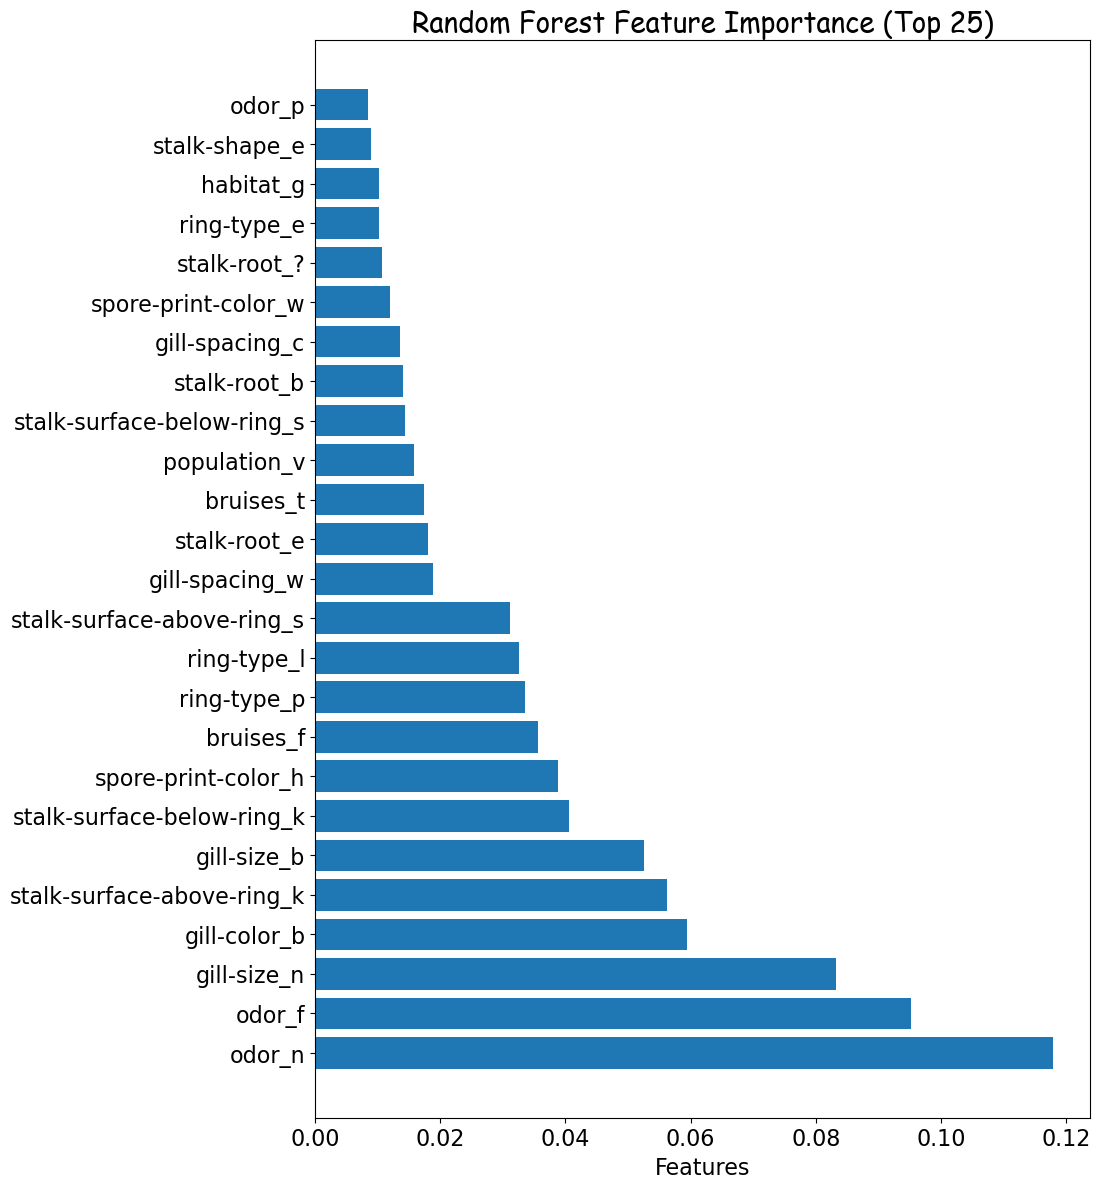

In [66]:
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [67]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}


In [68]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

In [69]:
# Create base model to tune
rf = RandomForestClassifier(oob_score=True)
# Create random search model and fit the data
rf_random = RandomizedSearchCV(
                        estimator = rf,
                        param_distributions = random_grid,
                        n_iter = 100, cv = 3,
                        verbose=2, random_state=seed, 
                        scoring='roc_auc')
rf_random.fit(X_train_encoded, y_train)
rf_random.best_params_
rf_random.best_params_
{'n_estimators': 206,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 44,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=5, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=5, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=49, min_samples_leaf=4, min_samples_split=5, n_estimators=565; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=467; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=467; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=467; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=10, n_estimators=161; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=10, n_estimators=161; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=10, n_estimators=161; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=10, n_estimators=675; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=10, n_estimators=675; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=10, n_estimators=675; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=44, min_samples_leaf=4, min_samples_split=2, n_estimators=577; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=44, min_samples_leaf=4, min_samples_split=2, n_estimators=577; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=44, min_samples_leaf=4, min_samples_split=2, n_estimators=577; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=60, max_features=auto, max_leaf_nodes=39, min_samples_leaf=10, min_samples_split=5, n_estimators=148; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=auto, max_leaf_nodes=39, min_samples_leaf=10, min_samples_split=5, n_estimators=148; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=auto, max_leaf_nodes=39, min_samples_leaf=10, min_samples_split=5, n_estimators=148; total time=   0.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2, n_estimators=565; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=467; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=467; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, max

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=50, max_features=log2, max_leaf_nodes=16, min_samples_leaf=10, min_samples_split=5, n_estimators=565; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=log2, max_leaf_nodes=16, min_samples_leaf=10, min_samples_split=5, n_estimators=565; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=log2, max_leaf_nodes=16, min_samples_leaf=10, min_samples_split=5, n_estimators=565; total time=   0.8s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=14, min_samples_leaf=10, min_samples_split=5, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=14, min_samples_leaf=10, min_samples_split=5, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=14, min_samples_leaf=10, min_samples_split=5, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=13, min_samples_leaf=10, min_samples_split=2, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=13, min_samples_leaf=10, min_samples_split=2, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, 

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=2, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=2, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=2, n_estimators=259; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_leaf_nodes=48, min_samples_leaf=10, min_samples_split=10, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_leaf_nodes=48, min_samples_leaf=10, min_samples_split=10, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_leaf_nodes=48, min_samples_leaf=10, min_samples_split=10, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=25, min_samples_leaf=1, min_samples_split=5, n_estimators=148; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, max_leaf_nodes=25, min_samples_leaf=1, min_samples_split=5, n_estimators=148; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=44, min_samples_leaf=1, min_samples_split=2, n_estimators=161; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=44, min_samples_leaf=1, min_samples_split=2, n_estimators=161; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=44, min_samples_leaf=1, min_samples_split=2, n_estimators=161; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=31, min_samples_leaf=1, min_samples_split=5, n_estimators=369; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=31, min_samples_leaf=1, min_samples_split=5, n_estimators=369; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=31, min_samples_leaf=1, min_samples_split=5, n_estimators=369; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=log2, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=2, n_estimators=638; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=log2, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=2, n_estimators=638; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=log2, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=2, n_estimators=638; total time=   0.9s
[CV] END bootstrap=False, max_depth=40, max_features=log2, max_leaf_nodes=29, min_samples_leaf=1, min_samples_split=10, n_estimators=393; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=log2, max_leaf_nodes=29, min_samples_leaf=1, min_samples_split=10, n_estimators=393; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=log2, max_leaf_nodes=29, min_samples_leaf=1, min_samples_split=10, n_estimators=393; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=16, min_samples_leaf=4, min_samples_split=5, n_estimators=638; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=16, min_samples_leaf=4, min_samples_split=5, n_estimators=638; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=16, min_samples_leaf=4, min_samples_split=5, n_estimators=638; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=2, n_estimators=210; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=2, n_estimators=210; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=2, n_estimators=210; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=381; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=381; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=381; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=31, min_samples_leaf=10, min_samples_split=2, n_estimators=491; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=31, min_samples_leaf=10, min_samples_split=2, n_estimators=491; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=31, min_samples_leaf=10, min_samples_split=2, n_estimators=491; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=41, min_samples_leaf=4, min_samples_split=5, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=41, min_samples_leaf=4, min_samples_split=5, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=41, min_samples_leaf=4, min_samples_split=5, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=10, min_samples_split=10, n_estimators=491; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=10, min_samples_split=10, n_estimators=491; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=10, min_samples_split=10, n_estimators=491; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=222; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=222; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=18, min_samples_leaf=1, min_samples_split=2, n_estimators=222; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=50, max_features=auto, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=2, n_estimators=442; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=auto, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=2, n_estimators=442; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=auto, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=2, n_estimators=442; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=10, n_estimators=210; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=10, n_estimators=210; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=10, n_estimators=210; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, max_leaf_nodes=37, min_samples_leaf=4, min_samples_split=10, n_estimators=112; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, max_leaf_nodes=37, min_samples_leaf=4, min_samples_split=10, n_estimators=112; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=70, max_features=auto, max_leaf_nodes=37, min_samples_leaf=4, min_samples_split=10, n_estimators=112; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=37, min_samples_leaf=4, min_samples_split=2, n_estimators=112; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=37, min_samples_leaf=4, min_samples_split=2, n_estimators=112; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=37, min_samples_leaf=4, min_samples_split=2, n_estimators=112; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=21, min_samples_leaf=4, min_samples_split=5, n_estimators=295; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=21, min_samples_leaf=4, min_samples_split=5, n_estimators=295; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=21, min_samples_leaf=4, min_samples_split=5, n_estimators=295; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=43, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=43, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=43, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=18, min_samples_leaf=4, min_samples_split=5, n_estimators=381; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=18, min_samples_leaf=4, min_samples_split=5, n_estimators=381; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=18, min_samples_leaf=4, min_samples_split=5, n_estimators=381; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5, n_estimators=418; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5, n_estimators=418; total time=   0.5s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=5, n_estimators=418; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=15, min_samples_leaf=1, min_samples_split=5, n_estimators=577; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=15, min_samples_leaf=1, min_samples_split=5, n_estimators=577; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=15, min_samples_leaf=1, min_samples_split=5, n_estimators=577; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, max_leaf_nodes=36, min_samples_leaf=4, min_samples_split=2, n_estimators=197; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, max_leaf_nodes=36, min_samples_leaf=4, min_samples_split=2, n_estimators=197; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, max_le

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=36, min_samples_leaf=1, min_samples_split=2, n_estimators=246; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=36, min_samples_leaf=1, min_samples_split=2, n_estimators=246; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=36, min_samples_leaf=1, min_samples_split=2, n_estimators=246; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_leaf_nodes=19, min_samples_leaf=4, min_samples_split=5, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_leaf_nodes=19, min_samples_leaf=4, min_samples_split=5, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, max_leaf_nodes=19, min_samples_leaf=4, min_samples_split=5, n_estimators=626; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=45, min_samples_leaf=1, min_samples_split=2, n_estimators=210; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=45, min_samples_leaf=1, min_samples_split=2, n_estimators=210; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=auto, max_leaf_nodes=45, min_samples_leaf=1, min_samples_split=2, n_estimators=210; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=45, min_samples_leaf=1, min_samples_split=2, n_estimators=393; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=45, min_samples_leaf=1, min_samples_split=2, n_estimators=393; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=45, min_samples_leaf=1, min_samples_split=2, n_estimators=393; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=50, max_features=log2, max_leaf_nodes=42, min_samples_leaf=4, min_samples_split=5, n_estimators=271; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=log2, max_leaf_nodes=42, min_samples_leaf=4, min_samples_split=5, n_estimators=271; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=log2, max_leaf_nodes=42, min_samples_leaf=4, min_samples_split=5, n_estimators=271; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=10, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=10, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=10, n_estimators=626; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=430; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=10, n_estimators=430; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=80, max_features=log2, max_leaf_nodes=27, min_samples_leaf=10, min_samples_split=2, n_estimators=197; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, max_leaf_nodes=27, min_samples_leaf=10, min_samples_split=2, n_estimators=197; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, max_leaf_nodes=27, min_samples_leaf=10, min_samples_split=2, n_estimators=197; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=log2, max_leaf_nodes=32, min_samples_leaf=4, min_samples_split=10, n_estimators=687; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=log2, max_leaf_nodes=32, min_samples_leaf=4, min_samples_split=10, n_estimators=687; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=log2, max_leaf_nodes=32, min_samples_leaf=4, min_samples_split=10, n_estimators=687; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=log2, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=2, n_estimators=161; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=log2, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=2, n_estimators=161; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=log2, 

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=19, min_samples_leaf=10, min_samples_split=5, n_estimators=687; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=19, min_samples_leaf=10, min_samples_split=5, n_estimators=687; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=19, min_samples_leaf=10, min_samples_split=5, n_estimators=687; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=16, min_samples_leaf=1, min_samples_split=2, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=16, min_samples_leaf=1, min_samples_split=2, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, max_leaf_nodes=16, min_samples_leaf=1, min_samples_split=2, n_estimators=589; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=222; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=222; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=log2, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=2, n_estimators=222; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=26, min_samples_leaf=1, min_samples_split=2, n_estimators=430; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=26, min_samples_leaf=1, min_samples_split=2, n_estimators=430; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=26, min_samples_leaf=1, min_samples_split=2, n_estimators=430; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=13, min_samples_leaf=4, min_samples_split=2, n_estimators=393; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=13, min_samples_leaf=4, min_samples_split=2, n_estimators=393; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=13, min_samples_leaf=4, min_samples_split=2, n_estimators=393; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=15, min_samples_leaf=4, min_samples_split=5, n_estimators=283; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=15, min_samples_leaf=4, min_samples_split=5, n_estimators=283; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=log2, max_leaf_nodes=15, min_samples_leaf=4, min_samples_split=5, n_estimators=283; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=13, min_samples_leaf=10, min_samples_split=5, n_estimators=332; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, max_leaf_nodes=13, min_samples_leaf=10, min_samples_split=5, n_estimators=332; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=14, min_samples_leaf=10, min_samples_split=5, n_estimators=136; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=14, min_samples_leaf=10, min_samples_split=5, n_estimators=136; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=14, min_samples_leaf=10, min_samples_split=5, n_estimators=136; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=28, min_samples_leaf=10, min_samples_split=5, n_estimators=308; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=28, min_samples_leaf=10, min_samples_split=5, n_estimators=308; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=28, min_samples_leaf=10, min_samples_split=5, n_estimators=308; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_samples_split=10, n_estimators=455; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_samples_split=10, n_estimators=455; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_samples_split=10, n_estimators=455; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=1, min_samples_split=5, n_estimators=430; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=1, min_samples_split=5, n_estimators=430; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=1, min_samples_split=5, n_estimators=430; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=27, min_samples_leaf=4, min_samples_split=10, n_estimators=369; total time=   0.6s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=27, min_samples_leaf=4, min_samples_split=10, n_estimators=369; total time=   0.5s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=27, min_samples_leaf=4, min_samples_split=10, n_estimators=369; total time=   0.5s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=46, min_samples_leaf=1, min_samples_split=10, n_estimators=565; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=46, min_samples_leaf=1, min_samples_split=10, n_estimators=565; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=46, min_samples_leaf=1, min_samples_split=10, n_estimators=565; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=5, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=5, n_estimators=589; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=5, n_estimators=589; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=28, min_samples_leaf=4, min_samples_split=2, n_estimators=344; total time=   0.5s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=28, min_samples_leaf=4, min_samples_split=2, n_estimators=344; total time=   0.5s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=28, min_samples_leaf=4, min_samples_split=2, n_estimators=344; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=442; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=442; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=442; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=4, min_samples_split=5, n_estimators=173; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=4, min_samples_split=5, n_estimators=173; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, max_leaf_nodes=41, min_samples_leaf=4, min_samples_split=5, n_estimators=173; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=344; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=344; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=5, n_estimators=344; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=33, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=33, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=33, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=14, min_samples_leaf=4, min_samples_split=10, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=14, min_samples_leaf=4, min_samples_split=10, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=log2, max_leaf_nodes=14, min_samples_leaf=4, min_samples_split=10, n_estimators=602; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=60, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=10, n_estimators=516; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=10, n_estimators=516; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=10, n_estimators=516; total time=   0.8s
[CV] END bootstrap=False, max_depth=80, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_samples_split=2, n_estimators=528; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_samples_split=2, n_estimators=528; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_samples_split=2, n_estimators=528; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=10, n_estimators=308; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, max_leaf_nodes=42, min_samples_leaf=10, min_samples_split=10, n_estimators=308; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, m

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=2, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=2, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=21, min_samples_leaf=10, min_samples_split=2, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=5, n_estimators=479; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=5, n_estimators=479; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=5, n_estimators=479; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, max_leaf_nodes=42, min_samples_leaf=1, min_samples_split=10, n_estimators=271; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, max_leaf_nodes=42, min_samples_leaf=1, min_samples_split=10, n_estimators=271; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, max_leaf_nodes=42, min_samples_leaf=1, min_samples_split=10, n_estimators=271; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=27, min_samples_leaf=1, min_samples_split=2, n_estimators=614; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=27, min_samples_leaf=1, min_samples_split=2, n_estimators=614; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=60, max_features=log2, max_leaf_nodes=27, min_samples_leaf=1, min_samples_split=2, n_estimators=614; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=log2, max_leaf_nodes=31, min_samples_leaf=1, min_samples_split=10, n_estimators=136; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=log2, max_leaf_nodes=31, min_samples_leaf=1, min_samples_split=10, n_estimators=136; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=log2, max_leaf_nodes=31, min_samples_leaf=1, min_samples_split=10, n_estimators=136; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=12, min_samples_leaf=10, min_samples_split=5, n_estimators=185; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=12, min_samples_leaf=10, min_samples_split=5, n_estimators=185; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, m

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=25, min_samples_leaf=1, min_samples_split=5, n_estimators=614; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=25, min_samples_leaf=1, min_samples_split=5, n_estimators=614; total time=   0.9s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=25, min_samples_leaf=1, min_samples_split=5, n_estimators=614; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=15, min_samples_leaf=1, min_samples_split=5, n_estimators=173; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=15, min_samples_leaf=1, min_samples_split=5, n_estimators=173; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=110, max_features=auto, max_leaf_nodes=15, min_samples_leaf=1, min_samples_split=5, n_estimators=173; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, max_leaf_nodes=31, min_samples_leaf=10, min_samples_split=2, n_estimators=393; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, max_leaf_nodes=31, min_samples_leaf=10, min_samples_split=2, n_estimators=393; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, max_leaf_nodes=31, min_samples_leaf=10, min_samples_split=2, n_estimators=393; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=46, min_samples_leaf=10, min_samples_split=5, n_estimators=112; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=46, min_samples_leaf=10, min_samples_split=5, n_estimators=112; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, max_leaf_nodes=46, min_samples_leaf=10, min_samples_split=5, n_estimators=112; total time=   0.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=2, n_estimators=222; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=2, n_estimators=222; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_samples_split=2, n_estimators=222; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_leaf_nodes=42, min_samples_leaf=1, min_samples_split=10, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=log2, max_

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=34, min_samples_leaf=4, min_samples_split=10, n_estimators=479; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=34, min_samples_leaf=4, min_samples_split=10, n_estimators=479; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=40, max_features=log2, max_leaf_nodes=34, min_samples_leaf=4, min_samples_split=10, n_estimators=479; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=5, n_estimators=479; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=5, n_estimators=479; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=5, n_estimators=479; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=24, min_samples_leaf=10, min_samples_split=5, n_estimators=479; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=24, min_samples_leaf=10, min_samples_split=5, n_estimators=479; total time=   0.8s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=None, max_features=auto, max_leaf_nodes=24, min_samples_leaf=10, min_samples_split=5, n_estimators=479; total time=   0.7s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, max_leaf_nodes=44, min_samples_leaf=10, min_samples_split=5, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, max_leaf_nodes=44, min_samples_leaf=10, min_samples_split=5, n_estimators=259; total time=   0.4s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=90, max_features=auto, max_leaf_nodes=44, min_samples_leaf=10, min_samples_split=5, n_estimators=259; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=2, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=2, n_estimators=602; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=2, n_estimators=602; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=36, min_samples_leaf=4, min_samples_split=10, n_estimators=136; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=36, min_samples_leaf=4, min_samples_split=10, n_estimators=136; total time=   0.2s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, max_leaf_nodes=36, min_samples_leaf=4, min_samples_split=10, n_estimators=136; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=516; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=516; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, max_leaf_nodes=48, min_samples_leaf=4, min_samples_split=2, n_estimators=516; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=18, min_samples_leaf=4, min_samples_split=2, n_estimators=332; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_leaf_nodes=18, min_samples_leaf=4, min_samples_split=2, n_estimators=332; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, max_l

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=19, min_samples_leaf=10, min_samples_split=5, n_estimators=234; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=19, min_samples_leaf=10, min_samples_split=5, n_estimators=234; total time=   0.3s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=20, max_features=log2, max_leaf_nodes=19, min_samples_leaf=10, min_samples_split=5, n_estimators=234; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=36, min_samples_leaf=10, min_samples_split=10, n_estimators=161; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=36, min_samples_leaf=10, min_samples_split=10, n_estimators=161; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=log2, max_leaf_nodes=36, min_samples_leaf=10, min_samples_split=10, n_estimators=161; total time=   0.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=10, n_estimators=638; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=10, n_estimators=638; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=10, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=10, n_estimators=638; total time=   1.0s


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 411, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(s

{'n_estimators': 206,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 44,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [70]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 50, cv = 3,
                verbose=1, random_state=seed,
                scoring='roc_auc')
pipe_random = make_pipeline(col_trans, rf_random)
pipe_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_va

{'n_estimators': 148,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 39,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [77]:
best_model = rf_random.best_estimator_
pipe_best_model = make_pipeline(col_trans, best_model)
pipe_best_model.fit(X_train, y_train)
y_pred_best_model = pipe_best_model.predict(X_test)

/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [78]:
n_nodes = []
max_depths = []
for ind_tree in best_model.estimators_:
       n_nodes.append(ind_tree.tree_.node_count)
       max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')  

Average number of nodes 50
Average maximum depth 10


/Users/yanyumao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Baseline: 1.0 
 Test: 1.0 
 Train: 1.0
Baseline: 0.48 
 Test: 1.0 
 Train: 1.0
Baseline: 0.5 
 Test: 1.0 
 Train: 1.0


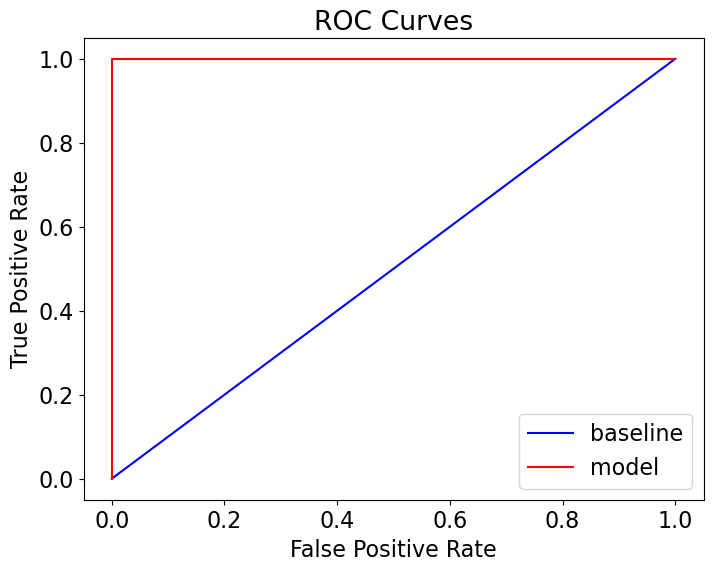

In [79]:
train_rf_predictions = pipe_best_model.predict(X_train)
train_rf_probs = pipe_best_model.predict_proba(X_train)[:, 1]
rf_probs = pipe_best_model.predict_proba(X_test)[:, 1]
# Plot ROC curve and check scores
evaluate_model(y_pred_best_model, rf_probs, train_rf_predictions, train_rf_probs)

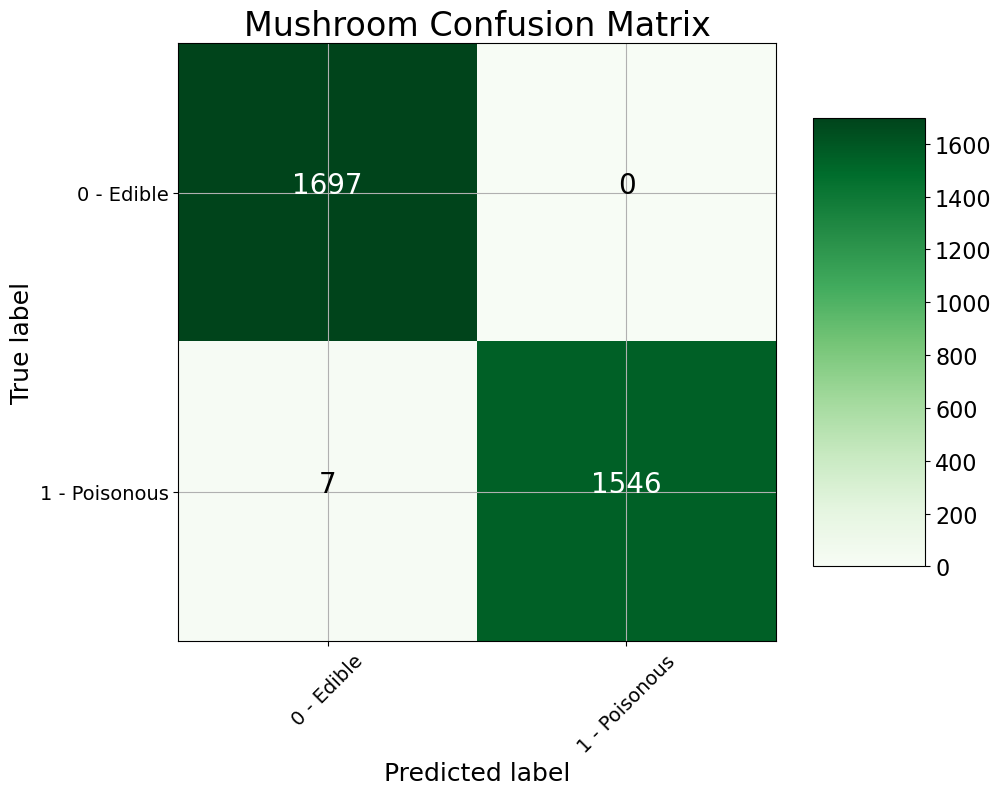

In [80]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_best_model), classes = ['0 - Edible', '1 - Poisonous'],
title = 'Mushroom Confusion Matrix')